# Figure 4

In [17]:
%load_ext autoreload
%autoreload 2

import itertools

import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform, cosine
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

from qian_et_al_2023.src import base
from qian_et_al_2023.src import chemistry
from qian_et_al_2023.src import data_loaders

base.set_visual_settings()
sns.set_style('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load and preprocess data

In [28]:
triplets = pd.read_csv('../data/triplets.csv', index_col=0)
triplets['Perceptual Distance'] = triplets['Perceptual Distance']/100 # Put into 0-1 range
triplets.head()

,SubjectCode,Triplet,Rep,RedJade Code A,roleA,RedJade Code B,roleB,Roles,Perceptual Distance,Structural Distance
0,P1,018 067 165,2,JBL,anchor,SOE,struct_cliff,anchor.to.struct_cliff,0.702,0.923
1,P1,018 067 165,2,JBL,anchor,JKT,label_cliff,anchor.to.label_cliff,1.187,0.594
2,P1,018 067 165,2,SOE,struct_cliff,JKT,label_cliff,struct_cliff.to.label_cliff,0.488,0.935
3,P1,018 067 165,1,JBL,anchor,SOE,struct_cliff,anchor.to.struct_cliff,0.611,0.923
4,P1,018 067 165,1,JBL,anchor,JKT,label_cliff,anchor.to.label_cliff,0.969,0.594


In [32]:
# Extract the actual triplet sets (3 molecules each)
anchors = triplets[triplets['roleA']=='anchor']['RedJade Code A'].unique().tolist()
triples = []
for anchor in anchors:
    label_cliffs = triplets[(triplets['roleA']=='anchor') &
                            (triplets['RedJade Code A']==anchor) &
                            (triplets['roleB']=='label_cliff')]['RedJade Code B'].unique().tolist()
    struct_cliffs = triplets[(triplets['roleA']=='anchor') &
                            (triplets['RedJade Code A']==anchor) &
                            (triplets['roleB']=='struct_cliff')]['RedJade Code B'].unique().tolist()
    for l, s in itertools.product(label_cliffs, struct_cliffs):
        queries = [f"roleA=='anchor' & `RedJade Code A`=='{anchor}' & `RedJade Code B`=='{s}'",
                   f"roleA=='anchor' & `RedJade Code A`=='{anchor}' & `RedJade Code B`=='{l}'"]
        if all([len(triplets.query(q)) for q in queries]):
            triples.append([anchor, s, l])

In [35]:
len(triples)

42

In [36]:
# Restrict to first molecule as anchor
triplets = triplets[triplets['roleA']=='anchor']
# Average perceptual distances across subjects
triplets_mean = triplets.groupby(['RedJade Code A', 'RedJade Code B', 'roleB']).mean(numeric_only=True)
triplets_sd = triplets.groupby(['RedJade Code A', 'RedJade Code B', 'roleB']).std(numeric_only=True)
triplets_n = triplets.groupby(['RedJade Code A', 'RedJade Code B', 'roleB']).count()
triplets_se = triplets_sd / np.sqrt(triplets_n)
triplets_mean.head()

Rep  Perceptual Distance  \
RedJade Code A RedJade Code B roleB                                      
AHP            CWE            struct_cliff  1.469                0.648   
               IZX            struct_cliff  1.469                0.506   
               PBI            struct_cliff  1.469                0.550   
               WTS            label_cliff   1.469                0.639   
ALM            AUC            label_cliff   1.469                0.607   

                                            Structural Distance  
RedJade Code A RedJade Code B roleB                              
AHP            CWE            struct_cliff                0.870  
               IZX            struct_cliff                1.000  
               PBI            struct_cliff                1.000  
               WTS            label_cliff                 0.467  
ALM            AUC            label_cliff                 0.529

In [49]:
rf_pred = pd.read_csv('../data/Data S4.csv', index_col=0)
gnn_pred = pd.read_csv('../data/Data S5.csv', index_col=0)

In [50]:
z = pdist(gnn_pred.values, metric='cosine')
z = pd.DataFrame(squareform(z),
                 index=gnn_pred.index,
                 columns=gnn_pred.index)
triplets_mean['Predicted Label Distance (GNN)'] = triplets_mean.index.map(
    lambda x: z.loc[x[0], x[1]])

z = pdist(rf_pred.values, metric='cosine')
z = pd.DataFrame(squareform(z),
                 index=rf_pred.index,
                 columns=rf_pred.index)
triplets_mean['Predicted Label Distance (RF)'] = triplets_mean.index.map(
    lambda x: z.loc[x[0], x[1]])

### Reproduce figure in manuscript and extend it

In [51]:
distances = ['Structural Distance',
             'Perceptual Distance',
             'Predicted Label Distance (GNN)',
             'Predicted Label Distance (RF)']
triples_df = pd.DataFrame(index=pd.MultiIndex.from_tuples(triples,
                                                          names=['anchor', 'struct', 'label']),
                          columns=pd.MultiIndex.from_product([['struct', 'label'], 
                                                              distances],
                                                             names=['leg', 'metric']))
triples_df = triples_df.sort_index()

In [52]:
for a, struct, label in triples_df.index:
    for d in distances:
        for smi, cliff in [(struct, "struct"), (label, "label")]:
            x = triplets_mean.loc[(a, smi), d].values
            assert len(x) == 1
            triples_df.loc[(a, struct, label), (cliff, d)] = x[0]

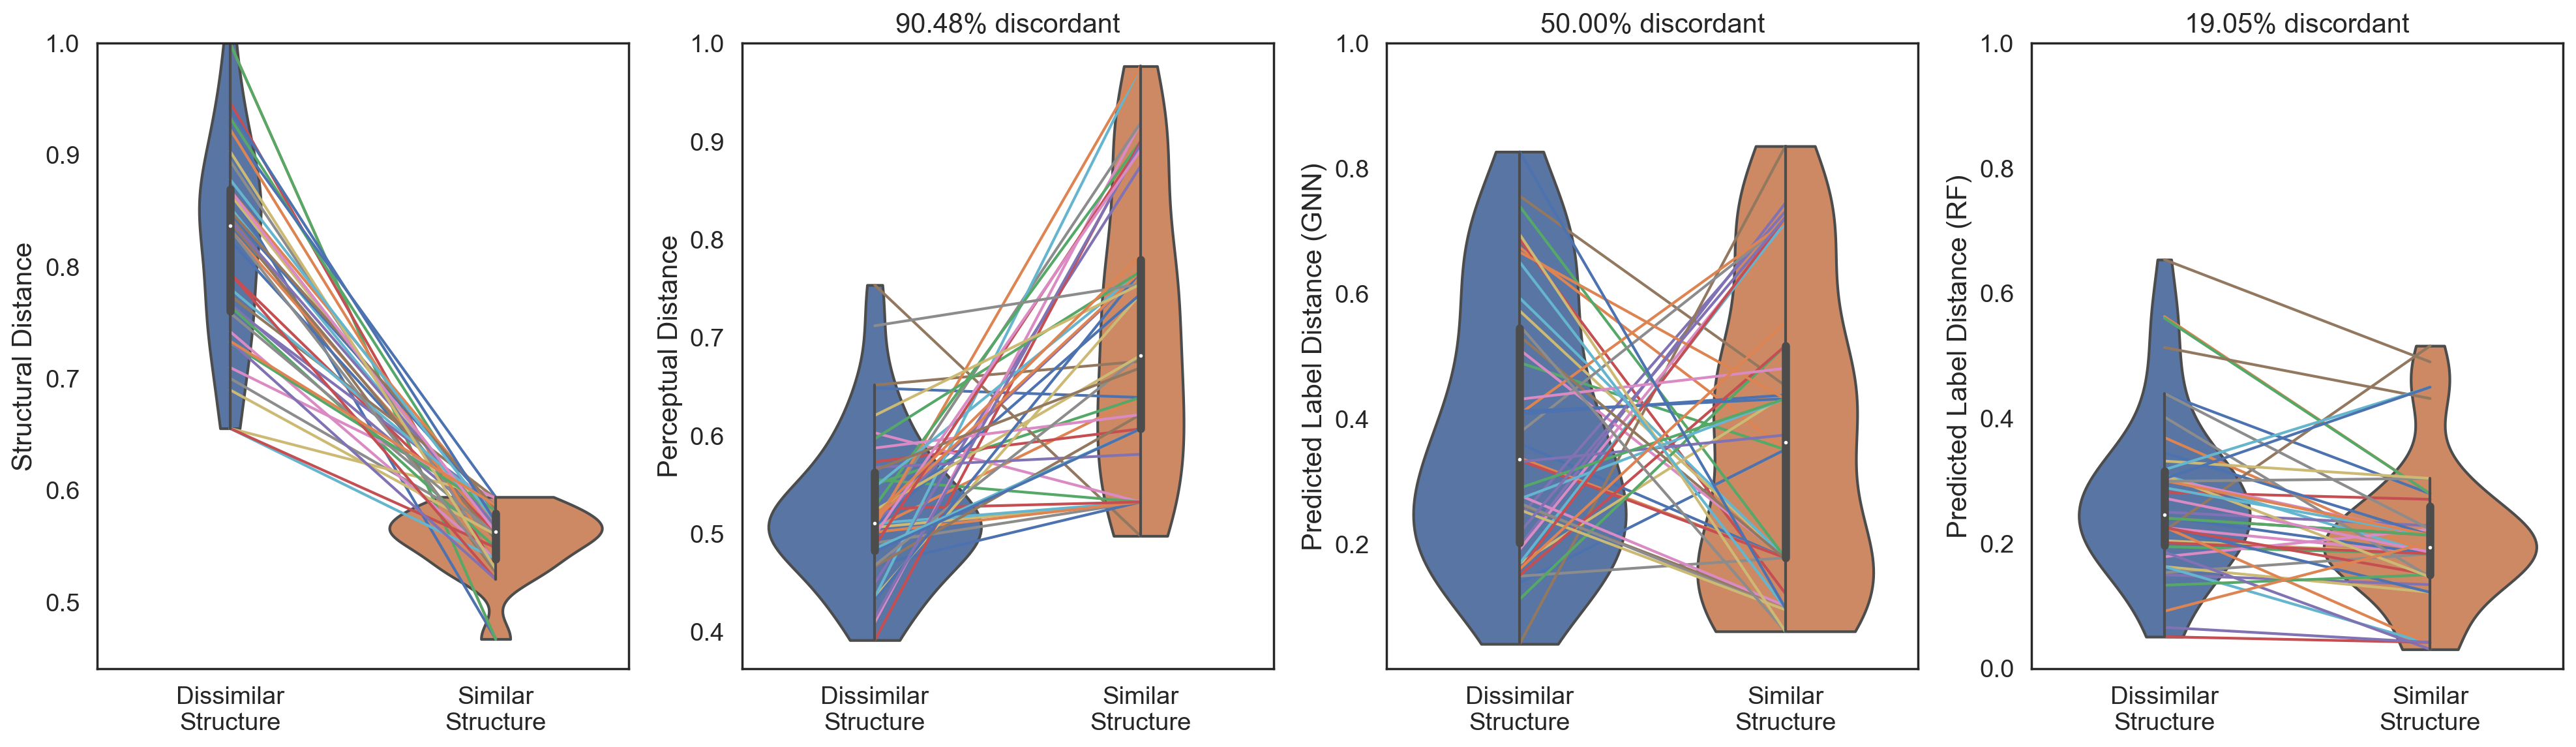

In [53]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
order = ['Dissimilar\nStructure', 'Similar\nStructure']
for ax, metric in zip(axes.flat, distances):
    z1 = triples_df.swaplevel(axis=1)[metric].T
    z1.index = order
    z1.plot(marker=None, ax=ax)
    sns.violinplot(data=z1.T, ax=ax, alpha=0.5, order=order, cut=0)
    ax.set_xlabel('')
    ax.set_ylabel(metric)
    ax.legend().remove()
    ax.set_ylim(None, 1)
    # Fraction of triplets correctly predicted by POM
    fract = (z1.diff().iloc[1, :]>0).mean()
    if metric != "Structural Distance":
        ax.set_title('%.2f%% discordant' % (fract*100))
plt.tight_layout()

In [ ]:
success_cnts = np.array([0.5000*42, 0.1905*42])
total_cnts = np.array([61, 61])
test_stat, pval = proportions_ztest(count=success_cnts, nobs=total_cnts, alternative='two-sided')
print('Two sided z-test: z = {:.4f}, p value = {:.4f}'.format(test_stat, pval))